

#Original



## **Importing libraries and datasets**

In [307]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [308]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [309]:
%cd /content/drive/MyDrive/Colab_Notebooks/NIDA_CRM/HW8/

/content/drive/MyDrive/Colab_Notebooks/NIDA_CRM/HW8


In [310]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [320]:
print('shape:')
print('response', df_response.shape,sep=' ')
print('transactions', df_transactions.shape,sep=' ')

shape:
response (6884, 2)
transactions (125000, 7)


In [311]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [312]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [313]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [314]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [316]:
random_state = 20
campaign_date = dt.datetime(2015,3,17)

df_transactions['days'] = (campaign_date - df_transactions['trans_date']).dt.days
df_transactions['weekend'] = df_transactions['trans_date'].dt.weekday.isin([5,6])

basket_cuts = [0,35,80,float('inf')]
df_transactions['basket_size'] = pd.cut(df_transactions['tran_amount'], basket_cuts, right=False, labels=['S','M','L'])

df_transactions = df_transactions.sort_values(['customer_id','trans_date'])
df_transactions.head()

,customer_id,trans_date,tran_amount,recent,days,weekend,basket_size
77247,CS1112,2011-06-15,56,1371.0,1371,False,M
89149,CS1112,2011-08-19,96,1306.0,1306,False,L
68206,CS1112,2011-10-02,60,1262.0,1262,True,M
36486,CS1112,2012-04-08,56,1073.0,1073,True,M
93074,CS1112,2012-06-24,52,996.0,996,True,M


In [317]:
print(df_transactions['trans_date'].max())
last_date = dt.datetime(2015,3,16)
print(f" 3 months: {last_date - dt.datetime(2014,12,16)}")
print(f" 6 months: {last_date - dt.datetime(2014,9,16)}")
print(f"12 months: {last_date - dt.datetime(2014,3,16)}")
print(f"18 months: {last_date - dt.datetime(2013,9,16)}")
print(f"24 months: {last_date - dt.datetime(2013,3,16)}")

2015-03-16 00:00:00
 3 months: 90 days, 0:00:00
 6 months: 181 days, 0:00:00
12 months: 365 days, 0:00:00
18 months: 546 days, 0:00:00
24 months: 730 days, 0:00:00


In [318]:
df = df_transactions.groupby('customer_id').agg(
        recency=('days', min),                       
        frequency=('customer_id', len),                  
        monetary=('tran_amount', sum), 
        tenure=('days', max),
        length_of_stay=('days', lambda x: x.max() - x.min()),
     )
# basket size stats
basket_size_df = df_transactions.groupby(['customer_id','basket_size'])['tran_amount'].agg(['size','sum']).unstack()
basket_size_df.columns = ['visit_basket_s','visit_basket_m','visit_basket_l','spend_basket_s','spend_basket_m','spend_basket_l']
df = df.join(basket_size_df)

df = df.join(df_transactions.groupby('customer_id').agg(
    ticket_size=('tran_amount','mean'),
    std_ticket_size=('tran_amount','std'),
    med_ticket_size=('tran_amount','median'),
    mad_ticket_size=('tran_amount','mad')
))

event_df = df_transactions.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
event_df['num_repeat_sameday'] = event_df['num_trans'] - 1
event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days

df = df.join(event_df.groupby('customer_id').agg(avg_duration=('duration','mean'),std_duration=('duration','std'),
                                                # med_duration=('duration','median'), mad_duration=('duration','mad'),
                                                num_repeat_periods=('trans_date', lambda x: x.count() - 1),
                                                num_repeat_sameday=('num_repeat_sameday','sum')))

# df['recency_score'] = (df['recency'] - df['avg_duration'])/df['std_duration']
df['recency_score'] = np.log(df['recency'] / df['avg_duration'])


# df = df.join(df_transactions.loc[df_transactions['trans_date'] > '2014-12-16'].groupby('customer_id')['tran_amount'].agg(monetary_3m='sum',frequency_3m='size'))
# df['ticket_size_3m'] = df['monetary_3m'] / df['frequency_3m']
# df['monthly_spend_3m'] = df['monetary_3m'] / 3
# df['monthly_visit_3m'] = df['frequency_3m'] / 3

df = df.join(df_transactions.loc[df_transactions['trans_date'] > '2014-09-16'].groupby('customer_id')['tran_amount'].agg(monetary_6m='sum',frequency_6m='size'))
df['ticket_size_6m'] = df['monetary_6m'] / df['frequency_6m']
df['monthly_spend_6m'] = df['monetary_6m'] / 6
df['monthly_visit_6m'] = df['frequency_6m'] / 6

df = df.join(df_transactions.loc[df_transactions['trans_date'] > '2014-03-16'].groupby('customer_id')['tran_amount'].agg(monetary_12m='sum',frequency_12m='size'))
df['ticket_size_12m'] = df['monetary_12m'] / df['frequency_12m']
df['monthly_spend_12m'] = df['monetary_12m'] / 12
df['monthly_visit_12m'] = df['frequency_12m'] / 12

df = df.join(df_transactions.loc[df_transactions['trans_date'] > '2013-09-16'].groupby('customer_id')['tran_amount'].agg(monetary_18m='sum',frequency_18m='size'))
df['ticket_size_18m'] = df['monetary_18m'] / df['frequency_18m']
df['monthly_spend_18m'] = df['monetary_18m'] / 18
df['monthly_visit_18m'] = df['frequency_18m'] / 18

df = df.join(df_transactions.loc[df_transactions['trans_date'] > '2013-03-16'].groupby('customer_id')['tran_amount'].agg(monetary_24m='sum',frequency_24m='size'))
df['ticket_size_24m'] = df['monetary_24m'] / df['frequency_24m']
df['monthly_spend_24m'] = df['monetary_24m'] / 24
df['monthly_visit_24m'] = df['frequency_24m'] / 24

# df['velocity_monetary_3_12'] = df['ticket_size_3m'] / df['monthly_spend_12m']
df['velocity_monetary_6_12'] = df['ticket_size_6m'] / df['monthly_spend_12m']
df['velocity_monetary_6_18'] = df['ticket_size_6m'] / df['monthly_spend_18m']
df['velocity_monetary_6_24'] = df['ticket_size_6m'] / df['monthly_spend_24m']
df['velocity_monetary_12_12'] = df['ticket_size_12m'] / df['monthly_spend_12m']
df['velocity_monetary_12_18'] = df['ticket_size_12m'] / df['monthly_spend_18m']
df['velocity_monetary_12_24'] = df['ticket_size_12m'] / df['monthly_spend_24m']


df.fillna(0, inplace=True)
#df = df_response.set_index('customer_id').join(df)
df

,recency,frequency,monetary,tenure,length_of_stay,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,recency_score,monetary_6m,frequency_6m,ticket_size_6m,monthly_spend_6m,monthly_visit_6m,monetary_12m,frequency_12m,ticket_size_12m,monthly_spend_12m,monthly_visit_12m,monetary_18m,frequency_18m,ticket_size_18m,monthly_spend_18m,monthly_visit_18m,monetary_24m,frequency_24m,ticket_size_24m,monthly_spend_24m,monthly_visit_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_12,velocity_monetary_12_18,velocity_monetary_12_24
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,62,15,1012,1371,1309,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,-0.410827,98.0,2.0,49.000000,16.333333,0.333333,251.0,4.0,62.750000,20.916667,0.333333,322.0,5.0,64.400000,17.888889,0.277778,358.0,6.0,59.666667,14.916667,0.250000,2.342629,2.739130,3.284916,3.0,3.507764,4.206704
CS1113,36,20,1490,1390,1354,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,-0.736928,220.0,3.0,73.333333,36.666667,0.500000,393.0,6.0,65.500000,32.750000,0.500000,446.0,7.0,63.714286,24.777778,0.388889,775.0,11.0,70.454545,32.291667,0.458333,2.239186,2.959641,2.270968,2.0,2.643498,2.028387
CS1114,33,19,1432,1342,1309,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,-0.790139,211.0,3.0,70.333333,35.166667,0.500000,315.0,5.0,63.000000,26.250000,0.416667,652.0,9.0,72.444444,36.222222,0.500000,804.0,11.0,73.090909,33.500000,0.458333,2.679365,1.941718,2.099502,2.4,1.739264,1.880597
CS1115,12,22,1659,1315,1303,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,-1.642995,55.0,1.0,55.000000,9.166667,0.166667,248.0,3.0,82.666667,20.666667,0.250000,590.0,8.0,73.750000,32.777778,0.444444,831.0,11.0,75.545455,34.625000,0.458333,2.661290,1.677966,1.588448,4.0,2.522034,2.387485
CS1116,204,13,857,1359,1155,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.751171,0.0,0.0,0.000000,0.000000,0.000000,286.0,4.0,71.500000,23.833333,0.333333,333.0,5.0,66.600000,18.500000,0.277778,333.0,5.0,66.600000,13.875000,0.208333,0.000000,0.000000,0.000000,3.0,3.864865,5.153153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CS8996,98,13,582,1218,1120,5,8,0,150.0,432.0,0.0,44.769231,18.749017,38.0,14.911243,93.333333,100.650912,12,0,0.048790,293.0,5.0,58.600000,48.833333,0.833333,336.0,6.0,56.000000,28.000000,0.500000,369.0,7.0,52.714286,20.500000,0.388889,369.0,7.0,52.714286,15.375000,0.291667,2.092857,2.858537,3.811382,2.0,2.731707,3.642276
CS8997,262,14,543,1378,1116,5,9,0,127.0,416.0,0.0,38.785714,14.000981,38.5,9.785714,85.846154,77.791223,13,0,1.115788,0.0,0.0,0.000000,0.000000,0.000000,45.0,1.0,45.000000,3.750000,0.083333,223.0,5.0,44.600000,12.388889,0.277778,246.0,6.0,41.000000,10.250000,0.250000,0.000000,0.000000,0.000000,12.0,3.632287,4.390244
CS8998,85,13,624,1378,1293,5,8,0,126.0,498.0,0.0,48.000000,22.319648,49.0,19.538462,107.750000,109.644985,12,0,-0.237162,82.0,2.0,41.000000,13.666667,0.333333,130.0,4.0,32.500000,10.833333,0.333333,130.0,4.0,32.500000,7.222222,0.222222,205.0,5.0,41.000000,8.541667,0.208333,3.784615,5.676923,4.800000,3.0,4.500000,3.804878


In [280]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()}) # Monetary Value

df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

In [281]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


## **Calculating response rate**

In [282]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


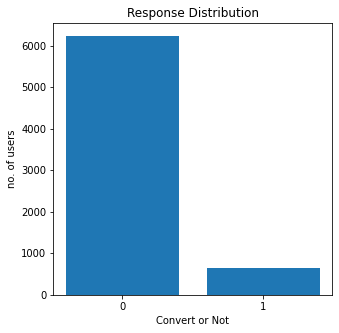

In [283]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [284]:
## merging two data sets

df_modeling = pd.merge(df_response,df_rfm)
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


## **Creating train and test dataset**

In [285]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [286]:
## spliting dataframe into X and y

#X = df_modeling.drop(columns=['response','customer_id'])
#y = df_modeling['response']

In [287]:
X = df.drop(columns=['response'])
y = df['response']

In [288]:
X.head(3)

,recency,frequency,monetary,tenure,length_of_stay,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,recency_score,monetary_6m,frequency_6m,ticket_size_6m,monthly_spend_6m,monthly_visit_6m,monetary_12m,frequency_12m,ticket_size_12m,monthly_spend_12m,monthly_visit_12m,monetary_18m,frequency_18m,ticket_size_18m,monthly_spend_18m,monthly_visit_18m,monetary_24m,frequency_24m,ticket_size_24m,monthly_spend_24m,monthly_visit_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_12,velocity_monetary_12_18,velocity_monetary_12_24
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,62,15,1012,1371,1309,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,-0.410827,98.0,2.0,49.000000,16.333333,0.333333,251.0,4.0,62.75,20.916667,0.333333,322.0,5.0,64.400000,17.888889,0.277778,358.0,6.0,59.666667,14.916667,0.250000,2.342629,2.739130,3.284916,3.0,3.507764,4.206704
CS1113,36,20,1490,1390,1354,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,-0.736928,220.0,3.0,73.333333,36.666667,0.500000,393.0,6.0,65.50,32.750000,0.500000,446.0,7.0,63.714286,24.777778,0.388889,775.0,11.0,70.454545,32.291667,0.458333,2.239186,2.959641,2.270968,2.0,2.643498,2.028387
CS1114,33,19,1432,1342,1309,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,-0.790139,211.0,3.0,70.333333,35.166667,0.500000,315.0,5.0,63.00,26.250000,0.416667,652.0,9.0,72.444444,36.222222,0.500000,804.0,11.0,73.090909,33.500000,0.458333,2.679365,1.941718,2.099502,2.4,1.739264,1.880597


In [289]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6884, 46)
Shape of y: (6884,)


In [290]:
pipeline = Pipeline([('standard_scaler', StandardScaler())])
X = pipeline.fit_transform(X)


Feature ranking:
1. feature 29 (0.041641)
2. feature 26 (0.040611)
3. feature 27 (0.035378)
4. feature 12 (0.034614)
5. feature 34 (0.033873)
6. feature 24 (0.033395)
7. feature 21 (0.033337)
8. feature 10 (0.033096)
9. feature 6 (0.032356)
10. feature 13 (0.032268)
11. feature 1 (0.032236)
12. feature 2 (0.032098)
13. feature 33 (0.031811)
14. feature 28 (0.031627)
15. feature 9 (0.031521)
16. feature 19 (0.031281)
17. feature 8 (0.031148)
18. feature 23 (0.030999)
19. feature 31 (0.030974)
20. feature 16 (0.030819)
21. feature 7 (0.030799)
22. feature 11 (0.029828)
23. feature 0 (0.029247)
24. feature 4 (0.029064)
25. feature 30 (0.027437)
26. feature 22 (0.026542)
27. feature 25 (0.025862)
28. feature 18 (0.023469)
29. feature 15 (0.023366)
30. feature 32 (0.023271)
31. feature 17 (0.022791)
32. feature 20 (0.022636)
33. feature 14 (0.012932)
34. feature 3 (0.004490)
35. feature 5 (0.003183)


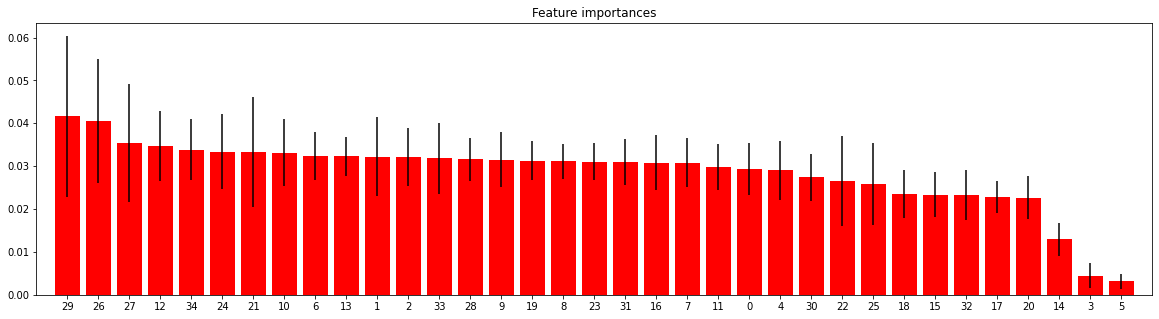

In [347]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier


# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=30,
                              random_state=1)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [300]:
X = df.drop(columns=['response','recency','length_of_stay','visit_basket_l','num_repeat_periods','recency_score','monetary_6m','monthly_spend_6m','monetary_12m','monthly_spend_12m','monthly_visit_24m','velocity_monetary_6_24'
])
y = df['response']

In [302]:
X.shape

(6884, 35)

In [293]:
X.head(3)

,frequency,monetary,tenure,visit_basket_s,visit_basket_m,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_sameday,frequency_6m,ticket_size_6m,monthly_visit_6m,frequency_12m,ticket_size_12m,monthly_visit_12m,monetary_18m,frequency_18m,ticket_size_18m,monthly_spend_18m,monthly_visit_18m,monetary_24m,frequency_24m,ticket_size_24m,monthly_spend_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_12_12,velocity_monetary_12_18,velocity_monetary_12_24
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,15,1012,1371,0,11,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,0,2.0,49.000000,0.333333,4.0,62.75,0.333333,322.0,5.0,64.400000,17.888889,0.277778,358.0,6.0,59.666667,14.916667,2.342629,2.739130,3.0,3.507764,4.206704
CS1113,20,1490,1390,0,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,1,3.0,73.333333,0.500000,6.0,65.50,0.500000,446.0,7.0,63.714286,24.777778,0.388889,775.0,11.0,70.454545,32.291667,2.239186,2.959641,2.0,2.643498,2.028387
CS1114,19,1432,1342,0,10,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,0,3.0,70.333333,0.500000,5.0,63.00,0.416667,652.0,9.0,72.444444,36.222222,0.500000,804.0,11.0,73.090909,33.500000,2.679365,1.941718,2.4,1.739264,1.880597


In [294]:
y.head(3)

customer_id
CS1112    0
CS1113    0
CS1114    1
Name: response, dtype: int64

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 35)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 35)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

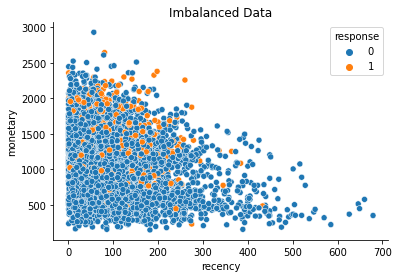

In [304]:
sns.scatterplot(data=df, x='recency', y='monetary', hue='response')
sns.despine()
plt.title("Imbalanced Data")

## **Fixing imbalanced with Undersampling**

In [306]:
X_train.head(1)

,frequency,monetary,tenure,visit_basket_s,visit_basket_m,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_sameday,frequency_6m,ticket_size_6m,monthly_visit_6m,frequency_12m,ticket_size_12m,monthly_visit_12m,monetary_18m,frequency_18m,ticket_size_18m,monthly_spend_18m,monthly_visit_18m,monetary_24m,frequency_24m,ticket_size_24m,monthly_spend_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_12_12,velocity_monetary_12_18,velocity_monetary_12_24
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS8706,12,564,1380,3,9,51.0,513.0,0.0,47.0,21.863211,48.5,18.166667,115.0,93.345594,0,1.0,68.0,0.166667,2.0,55.5,0.166667,222.0,4.0,55.5,12.333333,0.222222,232.0,5.0,46.4,9.666667,7.351351,5.513514,6.0,4.5,5.741379


In [321]:
X_train.shape

(4818, 35)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

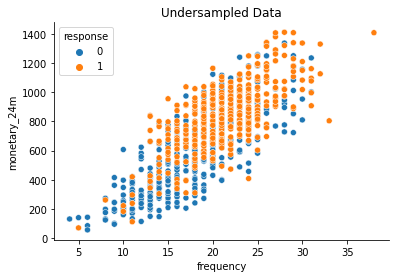

In [322]:
include_col = ['frequency','monetary','tenure','visit_basket_s','visit_basket_m','spend_basket_s','spend_basket_m','spend_basket_l','ticket_size','std_ticket_size','med_ticket_size','mad_ticket_size','avg_duration','std_duration','num_repeat_sameday','frequency_6m','ticket_size_6m','monthly_visit_6m','frequency_12m','ticket_size_12m','monthly_visit_12m','monetary_18m','frequency_18m','ticket_size_18m','monthly_spend_18m','monthly_visit_18m','monetary_24m','frequency_24m','ticket_size_24m','monthly_spend_24m','velocity_monetary_6_12','velocity_monetary_6_18','velocity_monetary_12_12','velocity_monetary_12_18','velocity_monetary_12_24'
,'response']

rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= include_col
sns.scatterplot(data=df_undersampled, x='frequency', y='monetary_24m', hue='response')
sns.despine()
plt.title("Undersampled Data")

## **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

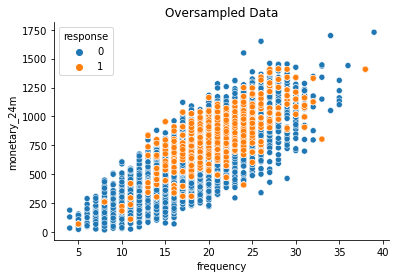

In [324]:
include_col = ['frequency','monetary','tenure','visit_basket_s','visit_basket_m','spend_basket_s','spend_basket_m','spend_basket_l','ticket_size','std_ticket_size','med_ticket_size','mad_ticket_size','avg_duration','std_duration','num_repeat_sameday','frequency_6m','ticket_size_6m','monthly_visit_6m','frequency_12m','ticket_size_12m','monthly_visit_12m','monetary_18m','frequency_18m','ticket_size_18m','monthly_spend_18m','monthly_visit_18m','monetary_24m','frequency_24m','ticket_size_24m','monthly_spend_24m','velocity_monetary_6_12','velocity_monetary_6_18','velocity_monetary_12_12','velocity_monetary_12_18','velocity_monetary_12_24'
,'response']

ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= include_col

sns.scatterplot(data=df_oversampled, x='frequency', y='monetary_24m', hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

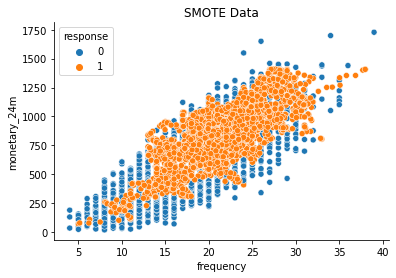

In [325]:
include_col = ['frequency','monetary','tenure','visit_basket_s','visit_basket_m','spend_basket_s','spend_basket_m','spend_basket_l','ticket_size','std_ticket_size','med_ticket_size','mad_ticket_size','avg_duration','std_duration','num_repeat_sameday','frequency_6m','ticket_size_6m','monthly_visit_6m','frequency_12m','ticket_size_12m','monthly_visit_12m','monetary_18m','frequency_18m','ticket_size_18m','monthly_spend_18m','monthly_visit_18m','monetary_24m','frequency_24m','ticket_size_24m','monthly_spend_24m','velocity_monetary_6_12','velocity_monetary_6_18','velocity_monetary_12_12','velocity_monetary_12_18','velocity_monetary_12_24'
,'response']

sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= include_col

sns.scatterplot(data=df_SMOTE, x='frequency', y='monetary_24m', hue='response')
sns.despine()
plt.title("SMOTE Data")

## **Logistic Regression Model**

In [326]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       429
           1       0.71      0.79      0.75       429

    accuracy                           0.73       858
   macro avg       0.74      0.73      0.73       858
weighted avg       0.74      0.73      0.73       858

test set
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1848
           1       0.20      0.76      0.32       218

    accuracy                           0.65      2066
   macro avg       0.58      0.70      0.54      2066
weighted avg       0.88      0.65      0.72      2066



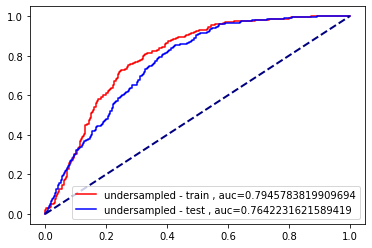

In [327]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

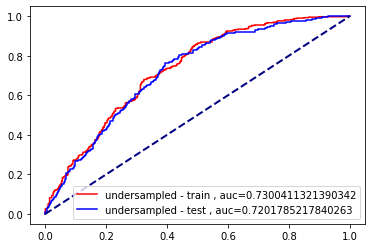

In [328]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[-3.92490117e-01  3.85356499e-03  2.27313911e-03 -1.91929862e-01
   2.40778311e-02  3.99258021e-03 -2.30890737e-04  9.18755290e-05
  -1.30151976e-01 -2.30023778e-01  2.89224043e-02  2.02131548e-01
  -2.50195614e-02 -1.09193662e-03  1.45298538e-01 -5.09758319e-02
   1.47611158e-02 -8.49597198e-03 -1.21170474e-01 -1.68498438e-02
  -1.00975395e-02 -6.49471202e-03  3.80607795e-01  6.18814885e-02
  -3.60817334e-04  2.11448775e-02  1.99635257e-04  3.88099077e-01
   4.24611452e-02  8.31813468e-06  6.04040449e-02 -6.01145082e-01
  -1.20469385e-01  1.56947123e-01  2.67121030e-01]] [-0.06252814]


In [329]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      4389
           1       0.69      0.77      0.73      4389

    accuracy                           0.71      8778
   macro avg       0.72      0.71      0.71      8778
weighted avg       0.72      0.71      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1848
           1       0.21      0.74      0.32       218

    accuracy                           0.68      2066
   macro avg       0.58      0.70      0.56      2066
weighted avg       0.88      0.68      0.74      2066



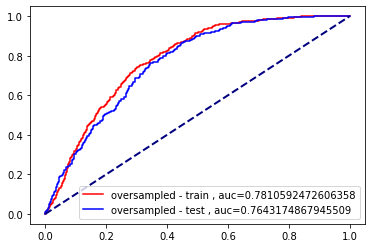

In [330]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

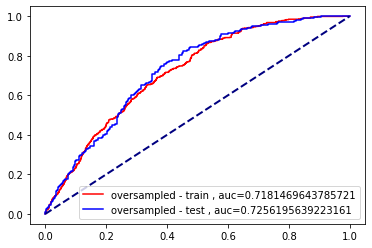

In [331]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[-2.86381267e-01  4.99331366e-03  2.63866532e-03 -4.15547688e-01
  -1.34151593e-01  8.87517289e-03 -6.42574670e-04 -3.23928518e-03
  -9.82671580e-02 -9.60205530e-02  3.70017088e-02  1.39101042e-01
  -3.14707672e-02 -4.66317524e-03  1.44648346e-01 -1.31103496e-01
   1.73905980e-02 -2.18505826e-02 -3.59183340e-02 -8.60709706e-04
  -2.99319450e-03 -2.52962954e-03  6.53441231e-02  1.21384232e-02
  -1.40534980e-04  3.63022906e-03 -6.97867613e-04  4.48819111e-01
   3.08441547e-02 -2.90778219e-05  9.51102113e-02 -7.01155726e-01
  -1.10794659e-01 -1.31427566e-02  3.81552028e-01]] [-0.06252814]


In [332]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.77      0.66      0.71      4389
           1       0.70      0.80      0.75      4389

    accuracy                           0.73      8778
   macro avg       0.74      0.73      0.73      8778
weighted avg       0.74      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.67      0.78      1848
           1       0.20      0.71      0.31       218

    accuracy                           0.67      2066
   macro avg       0.58      0.69      0.55      2066
weighted avg       0.87      0.67      0.73      2066



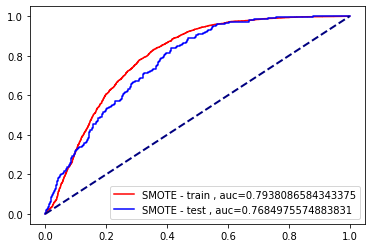

In [333]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

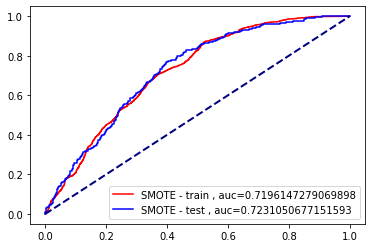

In [334]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[-4.82695638e-01  5.72954923e-03  4.98669955e-03 -3.70997359e-01
  -1.98141400e-01  7.29780921e-03  1.29393945e-03 -2.86219942e-03
  -1.17152264e-01 -1.50334700e-01  2.83247311e-02  2.24177975e-01
  -4.99061442e-02 -8.44614699e-03  2.34225631e-01 -1.44881798e-01
   1.16535927e-02 -2.41469663e-02  4.37886028e-03  4.24256366e-03
   3.64905023e-04 -6.00909174e-03  3.17292721e-01  3.04298752e-02
  -3.33838431e-04  1.76273734e-02  7.78848897e-04  3.59192565e-01
   3.38406113e-02  3.24520296e-05  1.03700337e-01 -5.59924487e-01
  -9.40015916e-02 -2.20781591e-02  2.26864344e-01]] [-0.06252814]


## **XGBoost**

In [335]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.732526
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.741493
[2]	validation_0-auc:0.75511
[3]	validation_0-auc:0.758554
[4]	validation_0-auc:0.759862
[5]	validation_0-auc:0.760073
[6]	validation_0-auc:0.759699
[7]	validation_0-auc:0.762474
[8]	validation_0-auc:0.762493
[9]	validation_0-auc:0.761339
[10]	validation_0-auc:0.762302
[11]	validation_0-auc:0.761897
[12]	validation_0-auc:0.76154
[13]	validation_0-auc:0.761208
Stopping. Best iteration:
[8]	validation_0-auc:0.762493

training set
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       429
           1       0.71      0.86      0.78       429

    accuracy                           0.76       858
   macro avg       0.77      0.76      0.75       858
weighted avg       0.77      0.76      0.75       858

test set
              precision    recall  f1-score   support

           0       0.97  

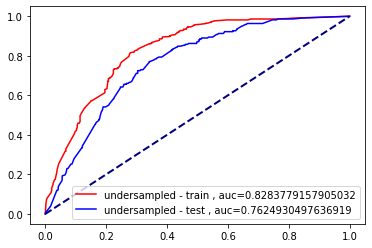

In [336]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

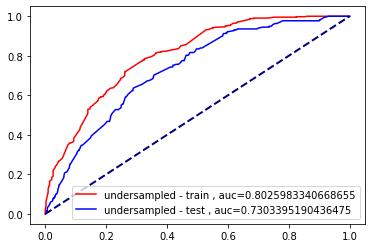

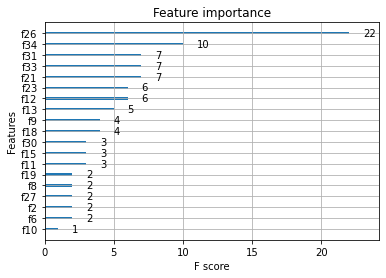

In [337]:
xgb.plot_importance(xgb_model_under)

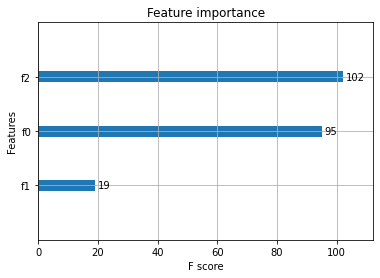

In [338]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.753155
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.760104
[2]	validation_0-auc:0.760007
[3]	validation_0-auc:0.762827
[4]	validation_0-auc:0.762911
[5]	validation_0-auc:0.764113
[6]	validation_0-auc:0.764242
[7]	validation_0-auc:0.764787
[8]	validation_0-auc:0.765231
[9]	validation_0-auc:0.765995
[10]	validation_0-auc:0.7662
[11]	validation_0-auc:0.766677
[12]	validation_0-auc:0.767951
[13]	validation_0-auc:0.768992
[14]	validation_0-auc:0.766484
[15]	validation_0-auc:0.765387
[16]	validation_0-auc:0.767687
[17]	validation_0-auc:0.770091
[18]	validation_0-auc:0.769381
[19]	validation_0-auc:0.769495
[20]	validation_0-auc:0.767683
[21]	validation_0-auc:0.76699
[22]	validation_0-auc:0.76822
Stopping. Best iteration:
[17]	validation_0-auc:0.770091

training set
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      4389
           1       0.71      0

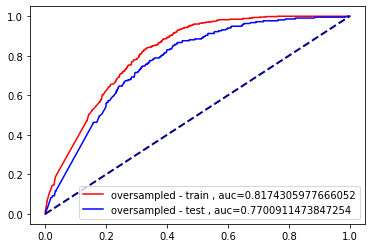

In [339]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

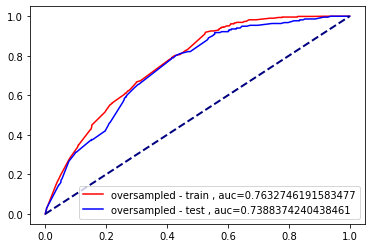

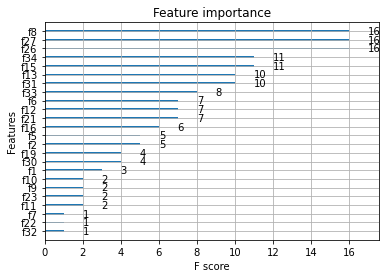

In [340]:
xgb.plot_importance(xgb_model_over)

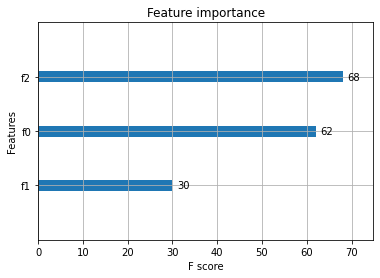

In [341]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.749078
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.757298
[2]	validation_0-auc:0.763289
[3]	validation_0-auc:0.76542
[4]	validation_0-auc:0.76735
[5]	validation_0-auc:0.767683
[6]	validation_0-auc:0.770516
[7]	validation_0-auc:0.770635
[8]	validation_0-auc:0.773122
[9]	validation_0-auc:0.771454
[10]	validation_0-auc:0.769596
[11]	validation_0-auc:0.770008
[12]	validation_0-auc:0.77028
[13]	validation_0-auc:0.770495
Stopping. Best iteration:
[8]	validation_0-auc:0.773122

training set
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      4389
           1       0.77      0.88      0.82      4389

    accuracy                           0.81      8778
   macro avg       0.82      0.81      0.81      8778
weighted avg       0.82      0.81      0.81      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.73

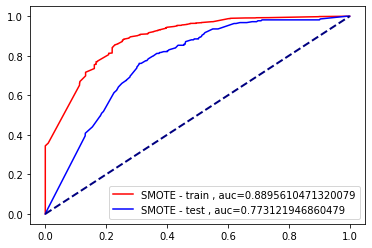

In [342]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

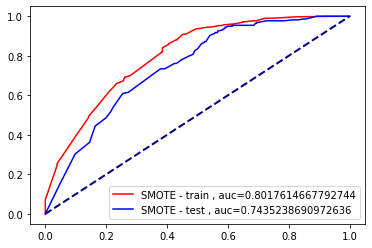

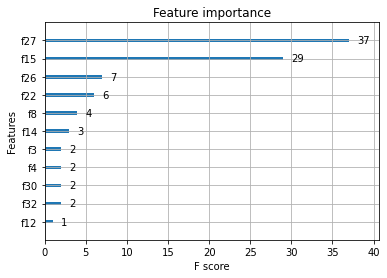

In [343]:
xgb.plot_importance(xgb_model_SMOTE)

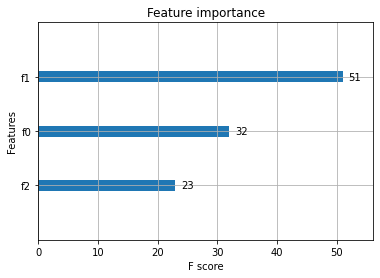

In [344]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.737447
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.751138
[2]	validation_0-auc:0.755918
[3]	validation_0-auc:0.763701
[4]	validation_0-auc:0.767743
[5]	validation_0-auc:0.76759
[6]	validation_0-auc:0.773097
[7]	validation_0-auc:0.77411
[8]	validation_0-auc:0.771231
[9]	validation_0-auc:0.772026
[10]	validation_0-auc:0.769675
[11]	validation_0-auc:0.769556
[12]	validation_0-auc:0.769236
Stopping. Best iteration:
[7]	validation_0-auc:0.77411

training set
              precision    recall  f1-score   support

           0       0.86      0.68      0.76      4389
           1       0.74      0.89      0.81      4389

    accuracy                           0.79      8778
   macro avg       0.80      0.79      0.78      8778
weighted avg       0.80      0.79      0.78      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.79  